In [1]:
## TiltedVwithSFR-SteadyState.py
# This script creates a square domain with the dimension
# 1000 m x 1000 m which is a tilted V ('open book') aquifer
# drained by a stream down the middle.
#
# Using default units of ITMUNI=4 (days) and LENUNI=2 (meters)
#
# Mostly figured out using this notebook: 
#   https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_sfrpackage_example.ipynb

import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import flopy.utils.sfroutputfile as sf
import pandas as pd

# where is your MODFLOW-2005 executable?
path2mf = '../../../../modflow/mf2005'
modelname = 'TiltedVwithSFR-SteadyState'
mf = flopy.modflow.Modflow(modelname, exe_name=path2mf)

/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:105: UserWarning: The program ../../../../modflow/mf2005 does not exist or is not executable.
  warn(


In [2]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
nlay = 1
nrow = 200
ncol = 201
delr = Lx / ncol
delc = Ly / nrow

In [38]:
# top and initial conditions
ztop = np.zeros((nrow,ncol), dtype='float')
ztop[0,:] = np.concatenate(
    [np.arange(25,19.9,-0.5), 
     np.arange(20.5,25.1,0.5)]
)

strt = np.zeros((nrow,ncol), dtype='float')
strt[0,:] = min(ztop[0,:]) + (max(ztop[0,:]) - min(ztop[0,:]))/2
for x in range(1, nrow):
    ztop[x,:] = ztop[x-1,:]-0.5
    strt[x,:] = min(ztop[x,:]) + (max(ztop[x,:]) - min(ztop[x,:]))/2

zbot = 0.0
delv = (ztop - zbot) / nlay
hk = 1.
vka = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1

ValueError: could not broadcast input array from shape (21,) into shape (201,)

In [12]:
xdemo = [0, 1, 2]
ydemo = [0, 2, 4]

for x,y in zip(xdemo, ydemo):
    print(x, y)

0 0
1 2
2 4


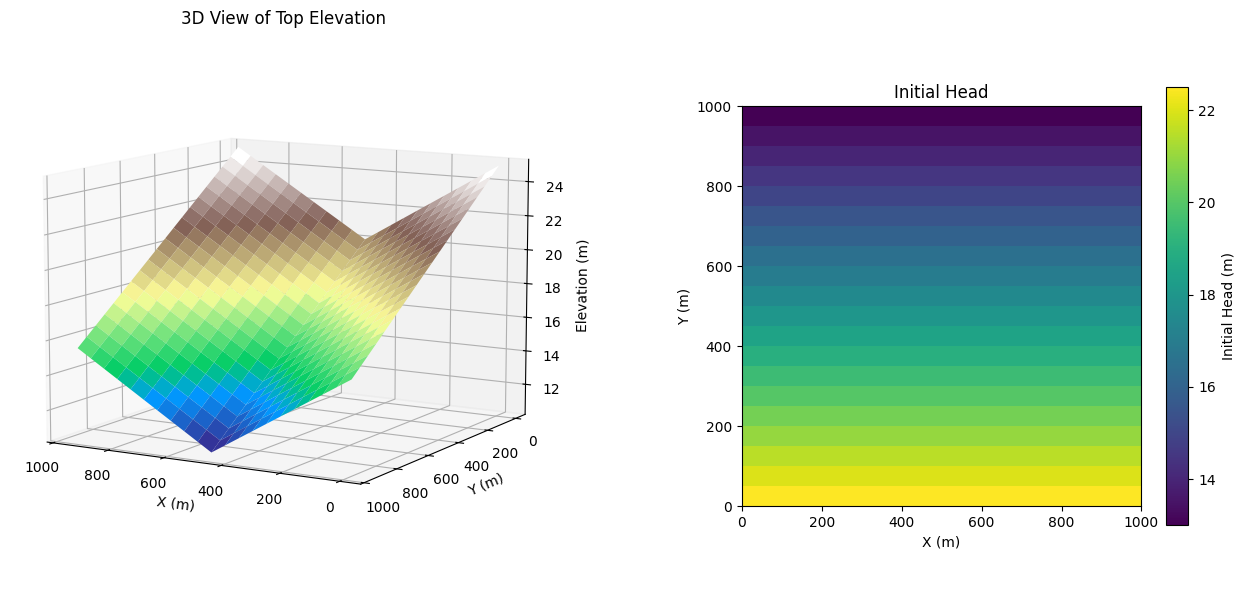

In [11]:
# Make a plot of the top and initial conditions
fig = plt.figure(figsize=(15, 6))

# Use gridspec for custom subplot sizing
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# First subplot - 3D surface plot (larger)
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.view_init(elev=10, azim=120)
X, Y = np.meshgrid(np.arange(0, Lx, delr), np.arange(0, Ly, delc))
ax1.plot_surface(X, Y, ztop, cmap='terrain', edgecolor='none')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Elevation (m)')
ax1.set_title('3D View of Top Elevation')

# Second subplot - 2D image plot (smaller)
ax2 = fig.add_subplot(gs[1])
ax2.set_aspect('equal')
im = ax2.imshow(strt, origin='lower', cmap='viridis', extent=(0, Lx, 0, Ly))
# Add colorbar for the second plot
plt.colorbar(im, ax=ax2, label='Initial Head (m)', shrink=0.8)
ax2.set_title('Initial Head')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

In [14]:
# define boundary conditions: 1 everywhere except 
# left and right edges, which are -1 (constant head)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,(0,ncol-1)] = -1.0

# Time step parameters (steady state)
nper = 1
perlen = [1]
nstp = [1]
steady = [True]
rchrate = 0.001  # [m/d]

In [17]:
# Flopy objects

# Discretization package
dis = flopy.modflow.ModflowDis(
    mf, 
    nlay, 
    nrow, 
    ncol, 
    delr=delr, 
    delc=delc,
    top=ztop, 
    botm=zbot,
    nper=nper, 
    perlen=perlen, 
    nstp=nstp, 
    steady=steady
)

# Basic package
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Layer property flow package
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp)

# Pcg package?
pcg = flopy.modflow.ModflowPcg(mf)

In [18]:
# recharge
rch = flopy.modflow.ModflowRch(mf, rech=rchrate, nrchop=3)

# output control
spd = {(0, 0): ['save head', 'save budget', 'save drawdown']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [21]:
## make stream network
# set up stream reach data (Dataset 2)
#  (KRCH, IRCH, JRCH, ISEG, IREACH)
slope=(ztop[0,10]-ztop[1,10])/delc
reach_data = np.array(
              [(0, 0, 10, 1, 1, delc, ztop[0,10]-1, slope, 1.0, hk/10),
               (0, 1, 10, 1, 2, delc, ztop[1,10]-1, slope, 1.0, hk/10),
               (0, 2, 10, 1, 3, delc, ztop[2,10]-1, slope, 1.0, hk/10),
               (0, 3, 10, 1, 4, delc, ztop[3,10]-1, slope, 1.0, hk/10),
               (0, 4, 10, 1, 5, delc, ztop[4,10]-1, slope, 1.0, hk/10),
               (0, 5, 10, 1, 6, delc, ztop[5,10]-1, slope, 1.0, hk/10),
               (0, 6, 10, 1, 7, delc, ztop[6,10]-1, slope, 1.0, hk/10),
               (0, 7, 10, 1, 8, delc, ztop[7,10]-1, slope, 1.0, hk/10),
               (0, 8, 10, 1, 9, delc, ztop[8,10]-1, slope, 1.0, hk/10),
               (0, 9, 10, 1, 10, delc, ztop[9,10]-1, slope, 1.0, hk/10),
               (0, 10, 10, 1, 11, delc, ztop[10,10]-1, slope, 1.0, hk/10),
               (0, 11, 10, 1, 12, delc, ztop[11,10]-1, slope, 1.0, hk/10),
               (0, 12, 10, 1, 13, delc, ztop[12,10]-1, slope, 1.0, hk/10),
               (0, 13, 10, 1, 14, delc, ztop[13,10]-1, slope, 1.0, hk/10),
               (0, 14, 10, 1, 15, delc, ztop[14,10]-1, slope, 1.0, hk/10),
               (0, 15, 10, 1, 16, delc, ztop[15,10]-1, slope, 1.0, hk/10),
               (0, 16, 10, 1, 17, delc, ztop[16,10]-1, slope, 1.0, hk/10),
               (0, 17, 10, 1, 18, delc, ztop[17,10]-1, slope, 1.0, hk/10),
               (0, 18, 10, 1, 19, delc, ztop[18,10]-1, slope, 1.0, hk/10),
               (0, 19, 10, 1, 20, delc, ztop[19,10]-1, slope, 1.0, hk/10)], 
      dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),
             ('strtop', '<f8'), ('slope', '<f8'), ('strthick', '<f8'), ('strhc1', '<f8')])

In [24]:
reach_data

array([(0.,  0., 10., 1.,  1., 50., 19. , 0.01, 1., 0.1),
       (0.,  1., 10., 1.,  2., 50., 18.5, 0.01, 1., 0.1),
       (0.,  2., 10., 1.,  3., 50., 18. , 0.01, 1., 0.1),
       (0.,  3., 10., 1.,  4., 50., 17.5, 0.01, 1., 0.1),
       (0.,  4., 10., 1.,  5., 50., 17. , 0.01, 1., 0.1),
       (0.,  5., 10., 1.,  6., 50., 16.5, 0.01, 1., 0.1),
       (0.,  6., 10., 1.,  7., 50., 16. , 0.01, 1., 0.1),
       (0.,  7., 10., 1.,  8., 50., 15.5, 0.01, 1., 0.1),
       (0.,  8., 10., 1.,  9., 50., 15. , 0.01, 1., 0.1),
       (0.,  9., 10., 1., 10., 50., 14.5, 0.01, 1., 0.1),
       (0., 10., 10., 1., 11., 50., 14. , 0.01, 1., 0.1),
       (0., 11., 10., 1., 12., 50., 13.5, 0.01, 1., 0.1),
       (0., 12., 10., 1., 13., 50., 13. , 0.01, 1., 0.1),
       (0., 13., 10., 1., 14., 50., 12.5, 0.01, 1., 0.1),
       (0., 14., 10., 1., 15., 50., 12. , 0.01, 1., 0.1),
       (0., 15., 10., 1., 16., 50., 11.5, 0.01, 1., 0.1),
       (0., 16., 10., 1., 17., 50., 11. , 0.01, 1., 0.1),
       (0., 17

In [22]:
# segment data (Dataset 6a-c)
#   (NSEG, ICALC, OUTSEG, IUPSEG, FLOW, RUNOFF, ETSW, PPTSW, ROUGHCH)
segment_data = {0: np.array([(1, 1, 0, 0, 
                              0, 0, 0, 0, 0.03, 
                              3, 3)],
                             dtype=[('nseg', '<f8'), ('icalc', '<f8'), ('outseg', '<f8'), ('iupseg', '<f8'), 
                                    ('flow', '<f8'), ('runoff', '<f8'), ('etsw', '<f8'), ('pptsw', '<f8'), ('roughch', '<f8'),
                                    ('width1', '<f8'), ('width2', '<f8')])}

In [23]:
# constants (dataset 1c)
nstrm = -len(reach_data) # number of reaches
nss = 1 # number of segments
nsfrpar = 0 # number of parameters (not supported)
nparseg = 0
const = 86400    # constant for manning's equation, units of m3/d
dleak = 0.00001 # closure tolerance for stream stage computation
ipakcb = 53 # ISTCB1= flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81 # flag for writing SFR output to text file
isfropt = 1  # no vertical unsat flow beneath streams
irtflg = 0

# dataset 5
dataset_5 = {0: [nss, 0, 0]} # [itmp, irdflag, iptflag]

sfr = flopy.modflow.ModflowSfr2(
    mf, nstrm=nstrm, nss=nss, const=const, dleak=dleak, ipakcb=ipakcb, istcb2=istcb2, 
    reach_data=reach_data,
    segment_data=segment_data,
    isfropt=isfropt,
    irtflg=irtflg,
    dataset_5=dataset_5,
    unit_number=16
)

In [25]:
# write input datasets
mf.write_input()

# run model
success, mfoutput = mf.run_model()
if not success:
    raise Exception('MODFLOW did not terminate normally.')

## look at head output
# Create the headfile object
h = bf.HeadFile(modelname+'.hds', text='head')

FloPy is using the following executable to run the model: ../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: TiltedVwithSFR-SteadyState.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/10/23 22:00:12

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/10/23 22:00:12
 Elapsed run time:  0.195 Seconds

  Normal termination of simulation


In [28]:
h.get_data().shape

(1, 20, 21)

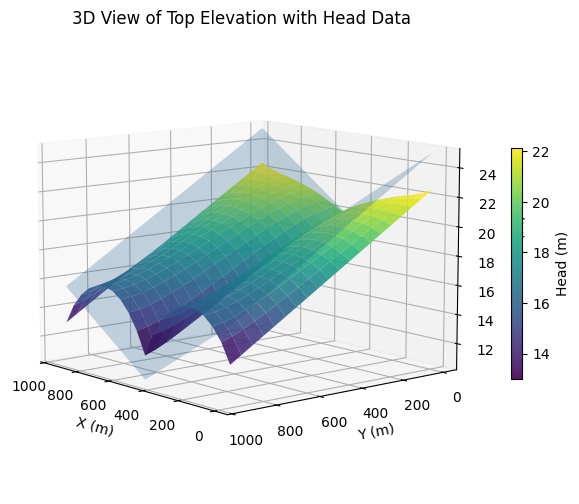

In [29]:
heads = h.get_data().squeeze()
heads[heads < -900] = np.nan
# Plot the head data, with a 3d view, showing the height of the top surface, but colored by head
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=140)
X, Y = np.meshgrid(np.arange(0, Lx, delr), np.arange(0, Ly, delc))
surf = ax.plot_surface(X, Y, ztop, alpha=0.25)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Elevation (m)')
ax.set_title('3D View of Top Elevation with Head Data')
# Overlay the head data
head_surface = ax.plot_surface(X, Y, heads, cmap='viridis', alpha=0.9, edgecolor='none')
plt.colorbar(head_surface, ax=ax, label='Head (m)', shrink=0.5)
plt.show()  

[<Axes: title={'center': ' SFR ireach data stress period 1 layer 1'}>]

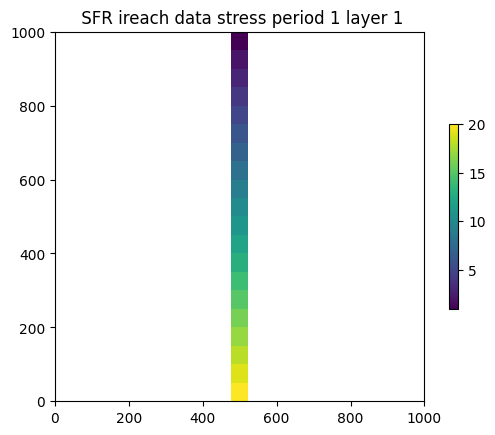

In [30]:
## look at sfr input/output
# sfr input
sfr.plot(key='ireach')


In [31]:
## look at sfr output file
sfrout = sf.SfrFile(modelname+'.sfr.out')
df = sfrout.get_dataframe()
df.head()


,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,1,11,1,1,0.000,-13.630,13.630,0.0,0.0,0.0,19.0009,0.000867,3.0,15.0,-0.9087,"(0, 0)",0,0,10
1,1,2,11,1,2,13.630,-18.230,31.860,0.0,0.0,0.0,18.5018,0.001787,3.0,15.0,-1.2150,"(0, 0)",0,1,10
2,1,3,11,1,3,31.860,-21.438,53.298,0.0,0.0,0.0,18.0026,0.002604,3.0,15.0,-1.4290,"(0, 0)",0,2,10
3,1,4,11,1,4,53.298,-23.797,77.095,0.0,0.0,0.0,17.5034,0.003362,3.0,15.0,-1.5860,"(0, 0)",0,3,10
4,1,5,11,1,5,77.095,-25.570,102.660,0.0,0.0,0.0,17.0041,0.004077,3.0,15.0,-1.7050,"(0, 0)",0,4,10


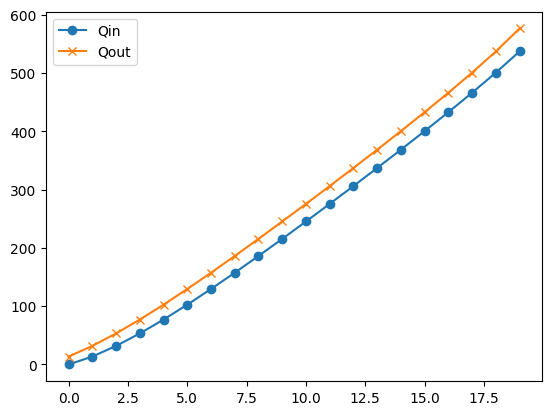

In [34]:
df['Qin'].plot(marker='o')
df['Qout'].plot(marker='x')
plt.legend()